# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)



```
# This is formatted as code
```

The data contains 541909 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df['CustomerID'].notna()]
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


Then we could do some descriptive statistic.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_minus = len(df[df['Quantity'] <= 0])
unitprice_zero = len(df[df['UnitPrice'] == 0])

percen_quantity_minus = (quantity_minus / len(df)) * 100
percen_unitprice_zero = (unitprice_zero / len(df)) * 100

print("The data consist of", str(quantity_minus), "rows of data with quantity less or equal than zero")
print("About", str(percen_quantity_minus), "% of the data")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero")
print("About", str(percen_unitprice_zero), "% of the data")

The data consist of 8905 rows of data with quantity less or equal than zero
About 2.188880340388714 % of the data
The data consist of 40 rows of data with unit price equal to zero
About 0.00983214077659164 % of the data


In [ ]:
Then just remove those anomaly data

In [ ]:
# Remove anomaly / outliers
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
# Check unique value
df[["InvoiceNo", "StockCode", "Description", "CustomerID", "Country"]].nunique()

,0
InvoiceNo,18532
StockCode,3665
Description,3877
CustomerID,4338
Country,37


There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

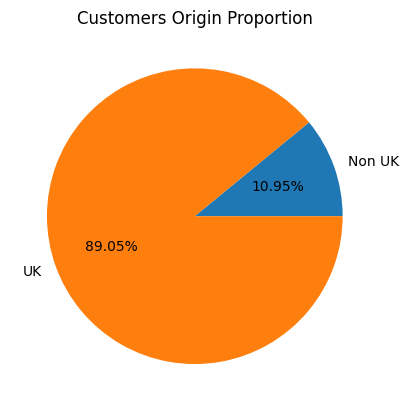

In [ ]:
# Simplify country origin (Pie chart untuk melihat komposisi negara)
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

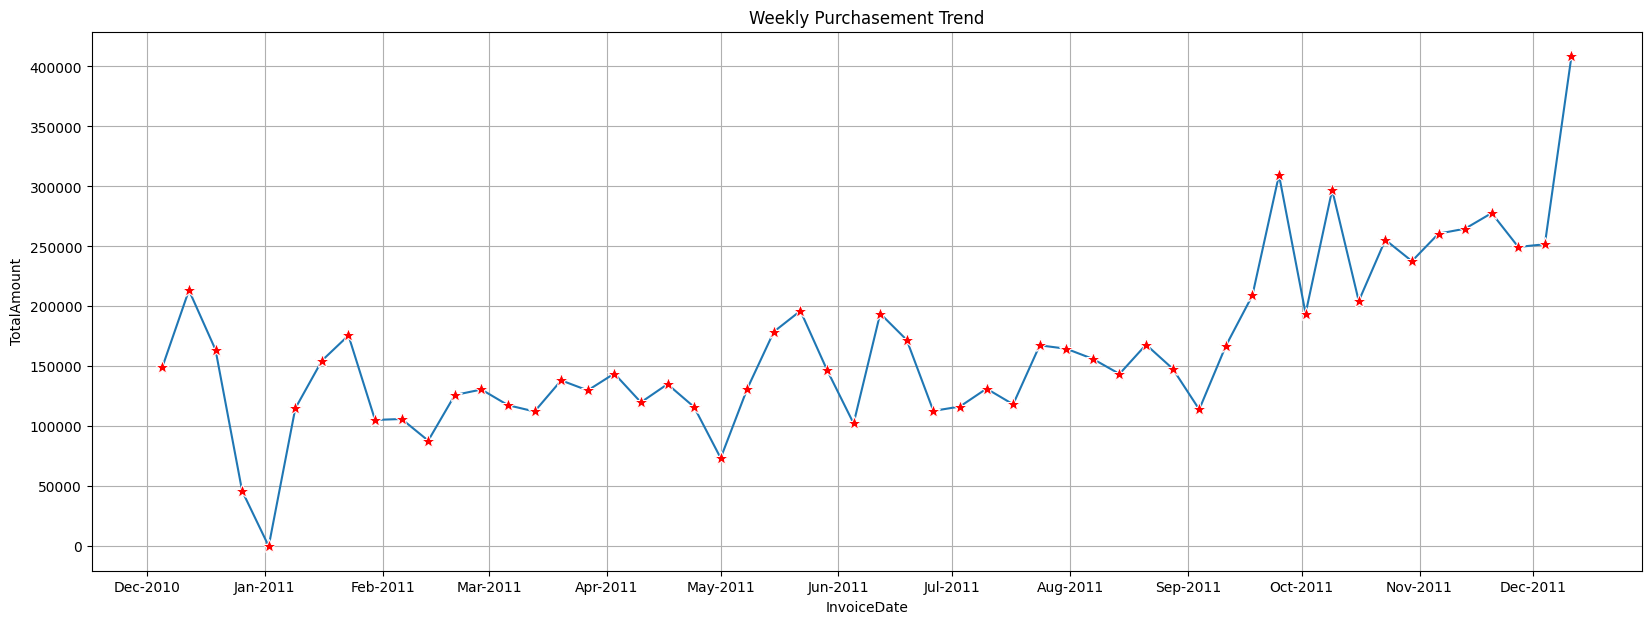

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

<ipython-input-23-5b277a02505f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()


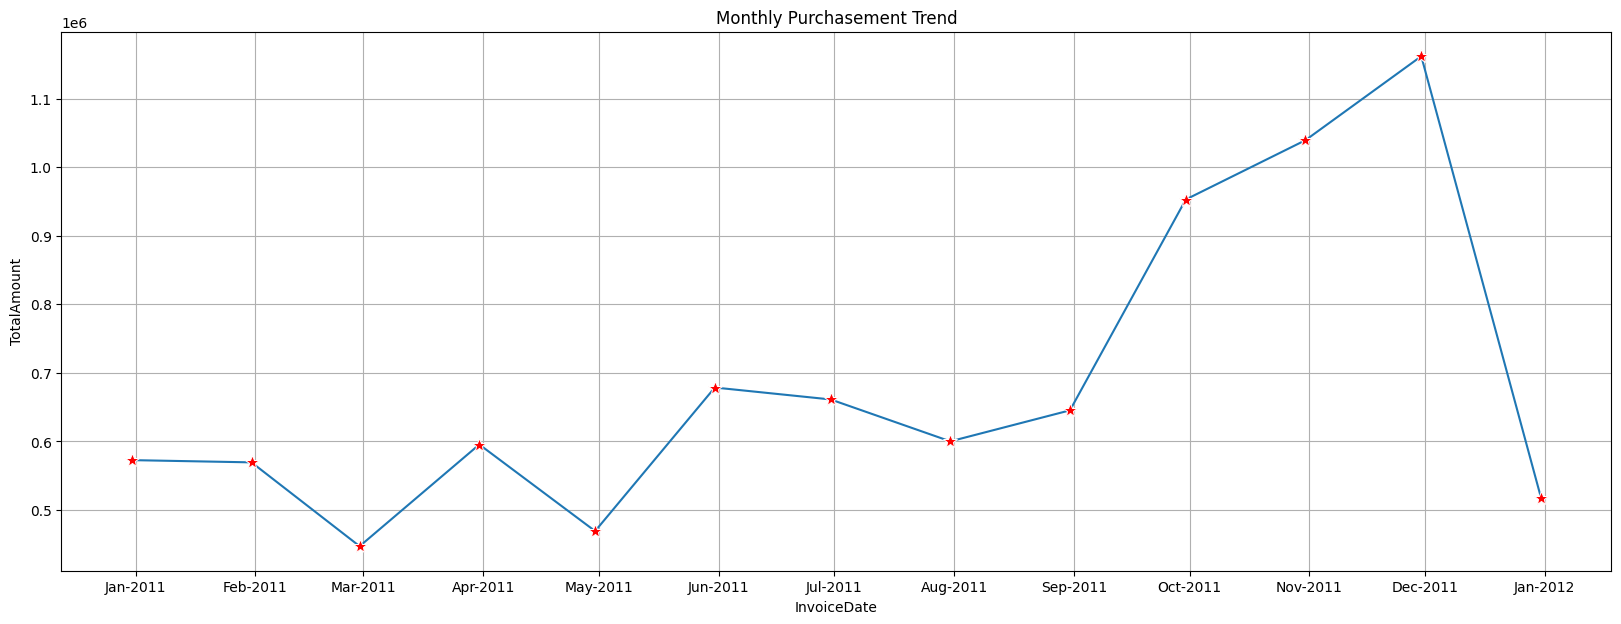

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby('CustomerID')['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days #convert to berapa hari
recency = recency.rename('Recency')
recency.head()


,Recency
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


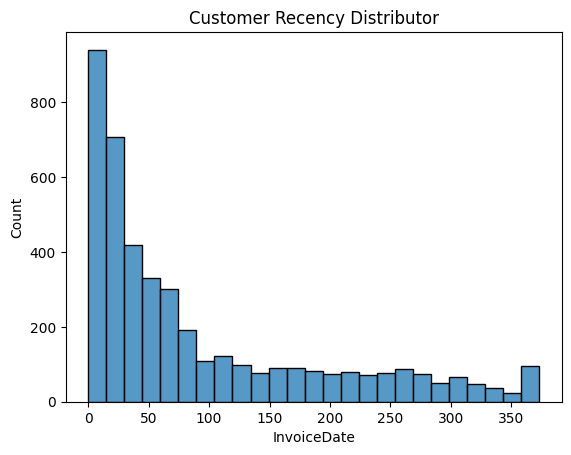

In [ ]:
# Recency histogram plot
plt.title ("Customer Recency Distributor")
sns.histplot(recency)
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()

,Frequency
CustomerID,
12346.0,1
12347.0,182
12348.0,31
12349.0,73
12350.0,17


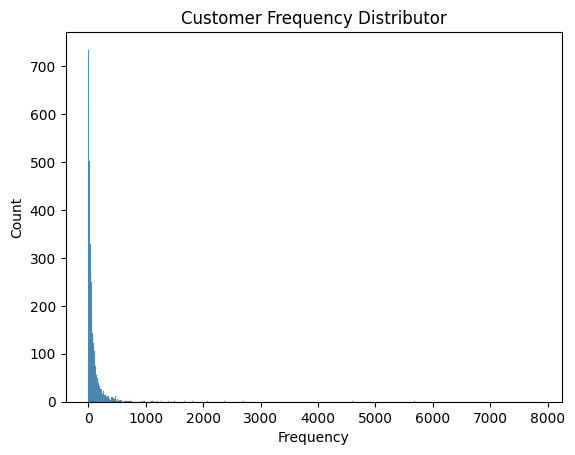

In [ ]:
# Frequency histogram plot
plt.title ("Customer Frequency Distributor")
sns.histplot(frequency)
plt.show()

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby('CustomerID')['TotalAmount'].sum()
monetary = monetary.rename('Monetary Spent')
monetary.head()

,Monetary Spent
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


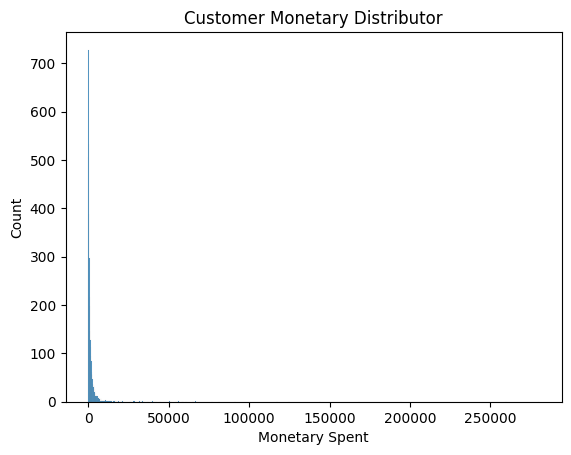

In [ ]:
# Monetary histogram plot
plt.title ("Customer Monetary Distributor")
sns.histplot(monetary)
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = country.merge(recency, on='CustomerID').merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
df_new.head()

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()


,Country_isUK,Recency,Frequency,Monetary Spent
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non-numeric variable
df_new = pd.get_dummies(df_new, columns=['Country_isUK'], drop_first=True, dtype=int)
df_new = df_new.rename(columns={'Country_isUK_UK': 'Country_isUK'})
df_new.head()

KeyError: "None of [Index(['Country_isUK'], dtype='object')] are in the [columns]"

### Scaling

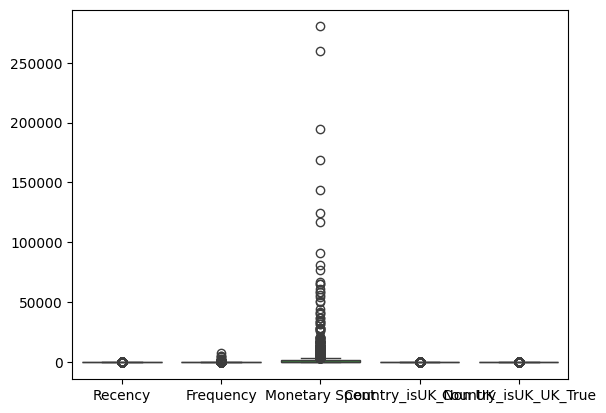

In [ ]:
sns.boxplot(data = df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_isUK_Non UK,Country_isUK_UK_True
CustomerID,,,,,
12346.0,2.334574,-0.396578,8.358668,-0.326547,0.326547
12347.0,-0.905340,0.394649,0.250966,3.062350,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,3.062350,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,3.062350,-3.062350
12350.0,2.174578,-0.326635,-0.191347,3.062350,-3.062350


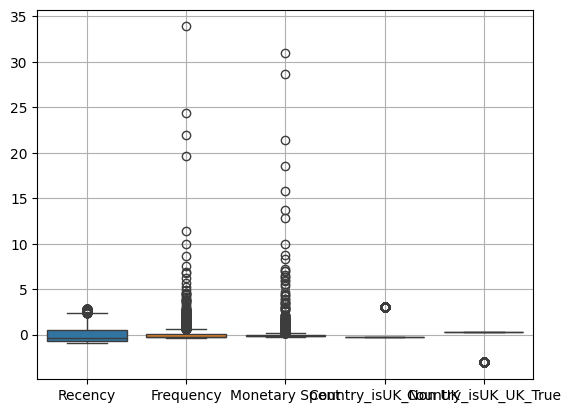

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

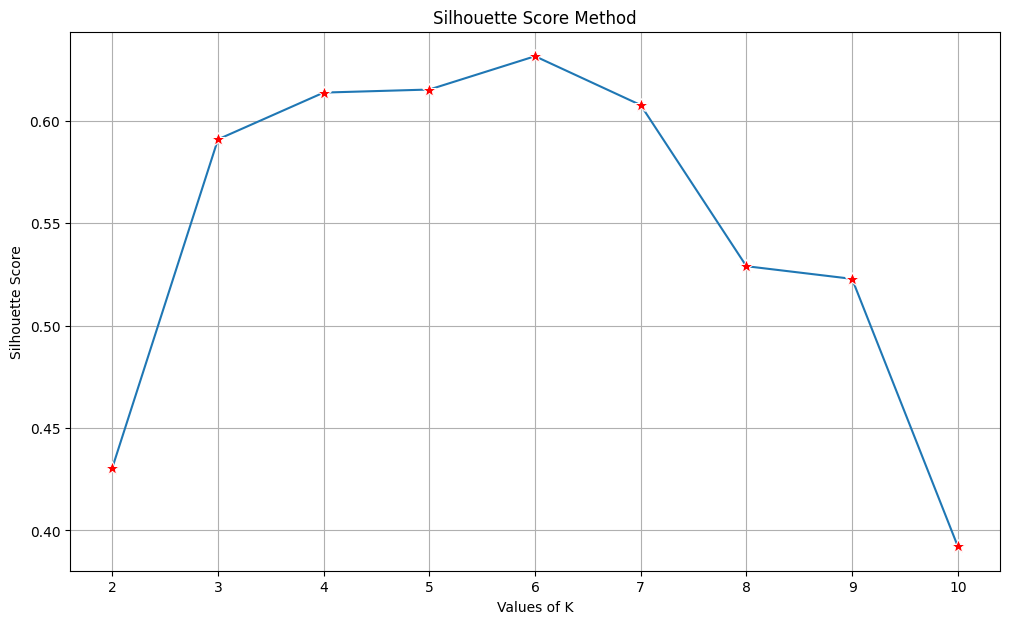

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is 2

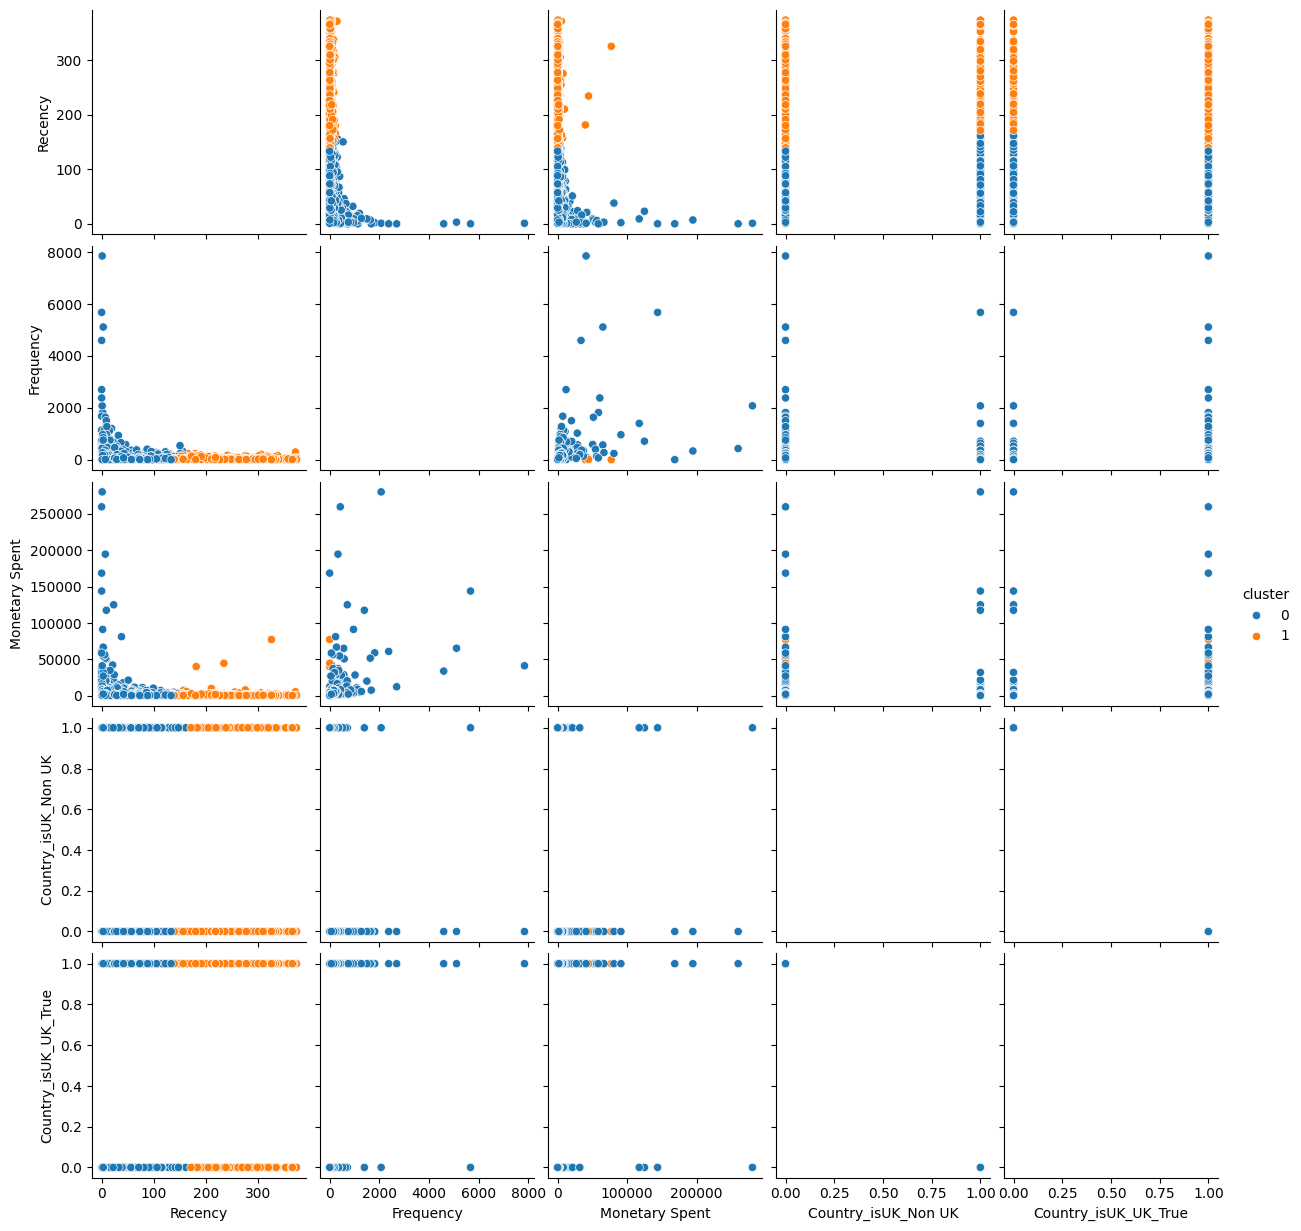

In [ ]:
#Pairplot
kmeans = KMeans(n_clusters=2,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_isUK_UK_True", axis=1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()

)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_isUK_UK_True"])["Recency"].count()

cluster  Country_isUK_UK_True
0        0                        325
         1                       2924
1        0                         93
         1                        996
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_isUK_UK_True"])["Frequency"].count()

cluster  Country_isUK_UK_True
0        0                        325
         1                       2924
1        0                         93
         1                        996
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_isUK_UK_True"])["Monetary Spent"].count()

cluster  Country_isUK_UK_True
0        0                        325
         1                       2924
1        0                         93
         1                        996
Name: Monetary Spent, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

In [ ]:
# Make a RFM metric to understand the top 5 customer by calculating the RFM score
# Rank customers by each RFM metric
df_new['MonetaryRank'] = df_new['Monetary Spent'].rank(ascending=False)
df_new['RecencyRank'] = df_new['Recency'].rank(ascending=True)  # Lower recency is better
df_new['FrequencyRank'] = df_new['Frequency'].rank(ascending=False)

# Calculate the overall RFM score
df_new['RFM_Score'] = df_new['MonetaryRank'] + df_new['RecencyRank'] + df_new['FrequencyRank']

# Get the top 5 customers based on the RFM score (lower score is better)
top_5_customers = df_new.sort_values('RFM_Score').head(5)

# Reset the index to access CustomerID as a column
top_5_customers = top_5_customers.reset_index()

top_5_customers[['CustomerID', 'Recency', 'Frequency', 'Monetary Spent', 'RFM_Score']]

,CustomerID,Recency,Frequency,Monetary Spent,RFM_Score
0,14911.0,0,5675,143825.06,54.0
1,15311.0,0,2379,60767.90,67.0
2,12748.0,0,4595,33719.73,79.0
3,17675.0,0,705,20374.28,127.0
4,14606.0,0,2700,12156.65,133.0


In [ ]:
df_new['RFM_Score'].sort_values().head()

,RFM_Score
CustomerID,
14911.0,54.0
15311.0,67.0
12748.0,79.0
17675.0,127.0
14606.0,133.0


In [ ]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
df['Hour'] = df['InvoiceDate'].dt.hour
df['Week'] = df['InvoiceDate'].dt.isocalendar().week

customer_activity = df.groupby(['Year', 'Month', 'DayOfWeek', 'Hour', 'Week'])['CustomerID'].nunique().reset_index()

top_day = customer_activity.groupby('DayOfWeek')['CustomerID'].sum().idxmax()
top_hour = customer_activity.groupby('Hour')['CustomerID'].sum().idxmax()
top_month = customer_activity.groupby('Month')['CustomerID'].sum().idxmax()
top_week = customer_activity.groupby('Week')['CustomerID'].sum().idxmax()

top_day, top_hour, top_month, top_week

(np.int32(3), np.int32(12), np.int32(11), np.uint32(48))

#Jawaban Question 2


cluster 0 (blue) characteristic = low recency low frequency low monetary majority = outside UK promotion =

free shipping and international shipping discount
discount percentage based on country distance from UK, the higher distance more higher the discount
cluster 1 (orange) characteristic = low recency high frequency high monetary majority = UK promotion =

high discount / premium discount by UK citizen (30% - 40%)
one day service on shipping strategy

#Jawaban Question 3

In [ ]:
df_new.head()

,Recency,Frequency,Monetary Spent,Country_isUK_Non UK,Country_isUK_UK_True
CustomerID,,,,,
12346.0,325,1,77183.60,False,1
12347.0,1,182,4310.00,True,0
12348.0,74,31,1797.24,True,0
12349.0,18,73,1757.55,True,0
12350.0,309,17,334.40,True,0


In [ ]:
df_new['Country_isUK_UK_True'] = df_new['Country_isUK_UK_True'].map({True: 1, False: 0})


In [ ]:
df_new.head()

,Recency,Frequency,Monetary Spent,Country_isUK_Non UK,Country_isUK_UK_True
CustomerID,,,,,
12346.0,325,1,77183.60,False,NaN
12347.0,1,182,4310.00,True,NaN
12348.0,74,31,1797.24,True,NaN
12349.0,18,73,1757.55,True,NaN
12350.0,309,17,334.40,True,NaN


<ipython-input-88-33e8327aedc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_uk_df['Cluster'] = kmeans_non_uk.fit_predict(X_scaled)


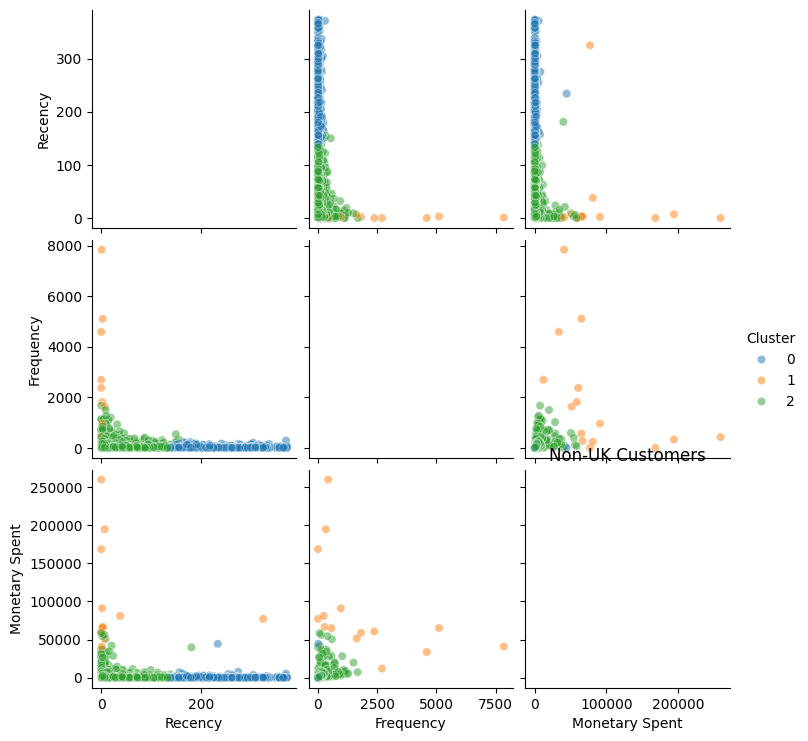

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

non_uk_df = df_new[df_new['Country_isUK_Non UK'] == 0]
X_non_uk = non_uk_df[['Recency', 'Frequency', 'Monetary Spent']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_non_uk)

kmeans_non_uk = KMeans(n_clusters=3, random_state=42)
non_uk_df['Cluster'] = kmeans_non_uk.fit_predict(X_scaled)

sns.pairplot(non_uk_df, hue='Cluster', diag_kind='none',palette='tab10', markers=["o", "o", "o"],
             plot_kws={'alpha': 0.5}, vars=['Recency', 'Frequency', 'Monetary Spent'])
plt.title('Non-UK Customers')

plt.show()

Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

cluster 1 orange adalah the most valuable dari non UK dan harus di boost agar lebih sering membeli dengan promo promo yang menarik seperti free shipping
cluster 0 blue dan 2 green adalah orang orang non UK berdaya beli lemah, butuh promosi yang sangat menarik untuk customer di cluster ini agar lebih engage